In [2]:
# Add the root location of the repo to sys.path in order to import modules
import os
print(os.getcwd())

# Change to Fork version of Pulser
import sys
sys.path.append('/Users/julienbremont/Documents/Pulserdev/Pulser')
sys.path

import numpy as np
import matplotlib.pyplot as plt
import qutip
from scipy.optimize import minimize
from qutip.measurement import measure_observable
from qutip.metrics import tracedist
import itertools

from pulser import Pulse, Sequence, Register
from pulser.simulation import Simulation, SimConfig
from pulser.waveforms import RampWaveform, ConstantWaveform
from pulser.devices import Chadoq2

/Users/julienbremont/Documents/Pulserdev/Shadowpy/Pulser/tutorials/applications


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Efficient estimation techniques for VQS

## Introduction

$\newcommand{\ket}[1]{\left|#1\right>} \newcommand{\bra}[1]{\left<#1\right|}$
This notebook's purpose is to introduce the concept of classical shadow estimation, as well as its use in **VQS** (**V**ariational **Q**uantum **S**imulation). This technique, introduced in [this article by Huang, Kueng and Preskill](https://arxiv.org/abs/2002.08953), is used for efficiently estimating multiple observables, and is extremely powerful in that regard, asymptotically reaching theoretical lower bounds of quantum information theory regarding the number of required samples of a given state for estimation ([see here for details](https://arxiv.org/abs/2101.02464)). 

The primary goal of this notebook is to estimate the groundstate energy of the $H_2$ molecule, using a VQS. We will first implement the method of random classical shadows in Python. Then, we'll introduce its derandomized counterpart, which is particularly useful in our setting. We'll finally describe the VQS, and benchmark the estimation methods we introduced for computing the molecule's energy. This notebook draws some inspiration from [this PennyLane Jupyter notebook](https://pennylane.ai/qml/demos/tutorial_classical_shadows.html) on quantum machine learning and classical shadows.

## Random classical shadows

### Main ideas and implementation

Classical shadow estimation relies on the fact that for a particular
choice of measurement, we can efficiently store snapshots of the state
that contain enough information to accurately predict linear functions
of observables.

Let us consider an $n$-qubit quantum state $\rho$ (prepared by a
pulse sequence) and apply a random unitary $U$ to the state:

$$\rho \to U \rho U^\dagger.$$

Next, we measure in the computational basis and obtain a bit string of
outcomes $|b\rangle = |0011\ldots10\rangle$. If the unitaries $U$ are
chosen at random from a particular ensemble, then we can store the
reverse operation $U^\dagger |b\rangle\langle b| U$ efficiently in
classical memory. We call this a *snapshot* of the state. Moreover, we
can view the average over these snapshots as a measurement channel:

$$\mathbb{E}\left[U^\dagger |b\rangle\langle b| U\right] = \mathcal{M}(\rho).$$

We restrict ourselves to unitary ensembles that define a tomographically complete set of
measurements (i.e $\mathcal{M}$ is invertible), therefore :

$$\rho = \mathbb{E}\left[\mathcal{M}^{-1}\left(U^\dagger |b\rangle\langle b| U \right)\right].$$

If we apply the procedure outlined above $N$ times, then the collection
of inverted snapshots is what we call the *classical shadow*

$$S(\rho,N) = \left\{\hat{\rho}_1= \mathcal{M}^{-1}\left(U_1^\dagger |b_1\rangle\langle b_1| U_1 \right)
,\ldots, \hat{\rho}_N= \mathcal{M}^{-1}\left(U_N^\dagger |b_N\rangle\langle b_N| U_N \right)
\right\}.$$

Since the shadow approximates $\rho$, we can now estimate **any**
observable with the empirical mean:

$$\langle O \rangle = \frac{1}{N}\sum_i \text{Tr}{\hat{\rho}_i O}.$$

We will be using a median-of-means procedure in practice.

We start by defining several useful quantities, such as the unitary matrices associated with Pauli measurements : the Hadamard matrix, change of basis from $\{\ket{0}, \ket{1}\}$ to the eigenbasis of $\sigma_X$, $\{\ket{+}, \ket{-}\}$, and its $\sigma_Y, \sigma_Z$ counterparts. We will then draw randomly from this tomographically complete set of $3$ unitaries.

Note that we will need $4$ qubits for our VQS problem : we will explain the mapping from the molecule to qubits later.

In [4]:
num_qubits = 4
zero_state = qutip.basis(2, 0).proj()
one_state = qutip.basis(2, 1).proj()
hadamard = 1/np.sqrt(2) * qutip.Qobj([[1., 1.], [1., -1.]])
h_mul_phase = qutip.Qobj(np.array([[1., 1], [1.j, -1.j]])) / np.sqrt(2)
unitary_ensemble = [hadamard, h_mul_phase, qutip.qeye(2)]

g = qutip.basis(2,1)
r = qutip.basis(2,0)
n = r*r.dag()

sx = qutip.sigmax()
sy = qutip.sigmay()
sz = qutip.sigmaz()

gggg = qutip.tensor([g, g, g, g])
ggrr = qutip.tensor([g, g, r, r])

We first define a function that spits out a random bitstring sampled from a given density matrix.

In [5]:
def measure_bitstring(state):
    """Auxiliary function that returns a bitstring according to the measure of a quantum state."""
    probs = np.real(state.diag())
    probs /= np.sum(probs)
    x = np.nonzero(np.random.multinomial(1, probs))[0][0]
    bitstring = np.binary_repr(x, num_qubits)
    return bitstring

We will need to compute the number of shadows needed given :
* A list of observables $o_i$
* Desired precision on expectation values $\epsilon$ : if $\tilde{o}_i$ is the estimated expectation value for observable $o_i$, we wish for $|Tr(o_i \rho) - \tilde{o}_i| \leq \epsilon$
* Failure probability $\delta$ : we wish for the above equation to be satisfied with probability $1-\delta$

Precise formulae are given in [Huang et al.](https://arxiv.org/abs/2002.08953)
The integer $K$ returned by the function will serve as the number of blocks in our median of means procedure afterwards.

In [6]:
def compute_shadow_size(delta, epsilon, observables):
    """Helper function.
    
    Computes both the number of shadows needed as well as the size of blocks needed 
    for the median_of_means method in order to approximate the expectation value of M
    (linear) observables with additive error epsilon and fail probability delta.
    
    Args:
        delta (float): Failure probability.
        epsilon (float): Additive error on expectation values.
        observables (list[qutip.Qobj]): Observables the expectation value of which is to be computed.
    """
    M = len(observables)
    K = 2 * np.log(2 * M / delta)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
            ) ** 2
        )
    #N = 34 * max(shadow_norm(o) for o in observables) / epsilon ** 2
    N = 20
    return int(np.ceil(N * K)), int(K)

Next, we design a function that returns snapshots (bitstrings) of the rotated state as well as the sampled unitaries used to rotate the state $\rho$.

In [7]:
def calculate_classical_shadow(rho, shadow_size):
    """
    Given a state rho, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes as bitstrings
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
    """
    # sample random Pauli measurements uniformly
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = []
    for ns in range(shadow_size):
        unitmat = qutip.tensor([unitary_ensemble[unitary_ids[ns, i]] for i in range(num_qubits)])
        outcomes.append(measure_bitstring(unitmat.dag() * rho * unitmat))

    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

We then reconstruct an estimate of the quantum state from the sampled bitstrings, using the inverse quantum channel $\mathcal{M}^{-1}$ defined above. In the particular case of Pauli measurements, we can actually compute the inverse channel : $$\mathcal{M}^{-1} = \otimes_{i=1}^n (3 U_i \ket{b_i}\bra{b_i} U^\dagger_i - \mathbb{1}_2)$$
where $i$ runs over all qubits : $\ket{b_i}$, $b_i \in \{0,1\}$, is the single-bit snapshot of qubit $i$ and $U_i$ is the sampled unitary corresponding to the snapshot, acting on qubit $i$.

In [8]:
def snapshot_state(outcome_ns, unitary_ids_ns):
    """
    Reconstructs an estimate of a state from a single snapshot in a shadow.

    Implements Eq. (S44) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        outcome_ns: Bitstring at ns
        unitary_ids_ns: Rotation applied at ns. 

    Returns:
        Reconstructed snapshot.
    """
    state_list = []
    
    for k in range(num_qubits):
        op = unitary_ensemble[unitary_ids_ns[k]]
        b = zero_state if outcome_ns[k] == '0' else one_state
        state_list.append(3 * op * b * op.dag() - qutip.qeye(2))
    
    return qutip.tensor(state_list)

We finally write a median of means procedure. We feed it an observable, the list of snapshots computed above and the number of blocks needed. It returns the median of the means of the observable acting on the snapshots in each block.

In [9]:
def _median_of_means(obs, snap_list, K):
    if K > len(snap_list):  # preventing the n_blocks > n_observations
        K = int(np.ceil(len(snap_list) / 2))
    # dividing seq in K random blocks
    indic = np.array((list(range(K)) * int(len(snap_list) / K)))
    np.random.shuffle(indic)
    # computing and saving mean per block
    means = []
    for block in range(K):
        states = [snap_list[i] for i in np.where(indic==block)[0]]
        exp = qutip.expect(obs, states)
        means.append(np.mean(exp))
    return np.median(means)

### Reconstructing a given quantum state

Let us try out the efficiency of this method. We will reconstruct a given density matrix from classical shadows estimation, and observe the evolution of the trace distance between the original state and its reconstruction according to the number of shadows used.

In [10]:
def state_reconstruction(snaps):
    return sum(snaps) / len(snaps)

In [11]:
num_qubits = 2
shadow_size = 10000
rho_1 = (qutip.tensor([qutip.basis(2,0), qutip.basis(2,0)]) + qutip.tensor([qutip.basis(2,0), qutip.basis(2,1)])).proj().unit()
print("Original density matrix :")
print(rho_1.full())
outcomes, unitary_ids = calculate_classical_shadow(rho_1, shadow_size)
snapshots = [snapshot_state(outcomes[ns], unitary_ids[ns]) for ns in range(shadow_size)]
print("Shadow reconstruction :")
print(np.around(state_reconstruction(snapshots).full(), 2))

dist = np.zeros(5)
for i, shadow_size in enumerate([100, 1000, 2000, 5000, 10000]):
    outcomes, unitary_ids = calculate_classical_shadow(rho_1, shadow_size)
    snapshots = [snapshot_state(outcomes[ns], unitary_ids[ns]) for ns in range(shadow_size)]
    dist[i] = tracedist(state_reconstruction(snapshots), rho_1)
num_qubits = 4

Original density matrix :
[[0.5+0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]]
Shadow reconstruction :
[[ 0.51+0.j    0.51+0.j   -0.  +0.02j -0.04-0.j  ]
 [ 0.51-0.j    0.49+0.j   -0.  +0.01j -0.01-0.01j]
 [-0.  -0.02j -0.  -0.01j -0.  +0.j   -0.01-0.01j]
 [-0.04+0.j   -0.01+0.01j -0.01+0.01j -0.  +0.j  ]]


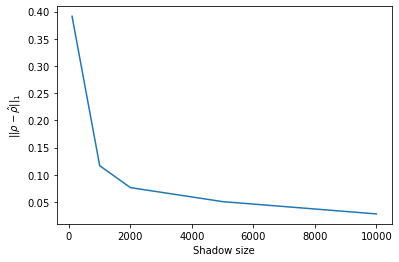

In [715]:
plt.plot([100, 1000, 2000, 5000, 10000], dist)
plt.xlabel("Shadow size")
plt.ylabel(r"$||\rho - \hat{\rho}||_1$")
plt.show()

As we can expect, the estimation gets better and better as shadow size gets larger, with about $2$% accuracy at $10000$ shadows. This mostly serves as a reality check, as we will be using classical shadows to estimate observables acting on quantum states, not to reconstruct those states.

## Derandomized Paulis

### Derandomization Algorithm

Randomized classical shadows are useful when dealing with low-weight, general observables. However, suppose, as is the case when estimating the Hamiltonian of the $H_2$ molecule written as a sum of Pauli strings, that we're dealing with Pauli observables of varying weights. In this setting, choosing wisely each Pauli measurement instead of randomly drawing a basis is particularly useful : indeed, say one wants to measure observable $\sigma_x^1 \otimes \sigma_x^2 \otimes \dots \otimes \sigma_x^n$. Using random rotations in each Pauli $X,Y$ or $Z$ basis and projection in the $Z$ (computational) basis, there is a probability $\frac{1}{3^n}$ to get each measurement basis right (i.e. rotate the system using the Hadamard matrix). This is extremely unlikely and unefficient as the number of qubits goes up. [Huang et al](https://arxiv.org/abs/2103.07510) outline an interesting greedy algorithm used for choosing suitable measurement bases for the efficient estimation of $L$ $n-$qubit Pauli strings, $\{O_i\}$. 

Feeding these observables as input, the algorithm aims at optimizing a certain cost function described in the above article, that takes as inputs chosen Pauli measurements $\{P_i\}$ as well as the observables. This function, labeled $Conf_\epsilon(O_i, P_j)$ is such that, if $Conf_\epsilon(O_i, P_j) \leq \frac{\delta}{2}$, then the empirical averages $\tilde{\omega_l}$ of each Pauli observable $O_l$ will be $\epsilon$-close to its true average $Tr(\rho O_l)$ with probability $1-\delta$.

In order to implement this cost function, we first need to design two auxiliary functions. The first one decides if a given Pauli measurement $p$ is compatible with ("hits") a Pauli observable $o$, meaning that on each qubit that $o$ acts non-trivially upon, it must act with the same Pauli matrix as $p$. We denote it by $o \vartriangleright
p$.

In [12]:
def hits(p, o, end=-1):
    """Determines if measurement p hits observable o

    Args:
        p (str): Pauli string in str format (ex "XYZ"), measurement
        o (str): same as above, observable (ex "11ZY")
        end (int): index before which to check if p hits o
    """
    if end != -1:
        o = o[:end]
    for i, x in enumerate(o):
        if not(x == p[i] or x == "1"):
            return False
    return True

The second function simply computes the number of qubits observable $o$ acts non-trivially upon.

In [13]:
def weight(o, start=0):
    o_k = o[start:]
    return len(o_k) - o_k.count("1")

We now implement the conditioned cost function using these auxiliary functions. We call it "conditioned", since we feed it only the first $m \times n + k$ single-qubit Pauli measurements, and average over the others, not yet determined ones.

In [14]:
def cond_conf(o, P_sharp):
    """Returns the (modified) conditionned expectation value of the cost function depending
    on already chosen Paulis in P_sharp.
    
    Args:
        o (list[str]): list of Pauli strings to be measured
        P_sharp (list[str]): list of already chosen Paulis
    """
    # Hyperparameters : see 
    eta = 0.9
    nu = 1 - np.exp(-eta / 2)
    L = len(o)
    m = len(P_sharp) - 1 # index of last chosen Pauli string
    k = len(P_sharp[-1]) - 1 # index of last chosen Pauli matrix in mth Pauli string
    result = 0
    for l in range(0, L):
        v = 0
        for m_prime in range(0,m):
            v += (eta / 2) * int(hits(P_sharp[m_prime], o[l]))
        v -= np.log(1 - (nu / 3**(weight(o[l], start=k+1))) * hits(P_sharp[m], o[l], end=k+1))
        result += np.exp(-v)
    return result

Finally, we design a simple greedy algorithm which purpose is to minimize this conditioned cost function, choosing one single-qubit Pauli at a time.

In [15]:
def derandomization(M, o):
    """Derandomization algorithm returning best Pauli indices according to a greedy algorithm
    that aims at minimizing the cost function above.
    
    Args:
        M (int): number of measurements
        n (int): number of qubits (size of Pauli strings)
        epsilon (float): desired accuracy on observable expectation values
        o (list[str]): list of Pauli strings to be measured
    """
    n = len(o[0])
    P_sharp = []
    for m in range(M):
        P_sharp.append("")
        for k in range(n):
            P_sharp_m = P_sharp[m]
            P_sharp[m] += "X"
            valmin = cond_conf(o, P_sharp)
            argmin = "X"
            for W in ["Y", "Z"]:
                P_sharp[m] = P_sharp_m + W
                val_W = cond_conf(o, P_sharp)
                if val_W < valmin:
                    valmin = val_W
                    argmin = W
            P_sharp[m] = P_sharp_m + argmin
    return P_sharp

### Estimating expectation values from Pauli measurements

Now that we have our Pauli measurements, we proceed differently from randomized classical shadows, where we gave an estimate of the actual quantum channels. Here, we're only interested in the Pauli averages $\tilde{\omega}_l$, that we can infer from Pauli measurements $p$ that **hit** observable $o_l$. Indeed, we have the following formula :
$$\tilde{\omega}_{l}=\frac{1}{h\left(\mathbf{o}_{l} ;\left[\mathbf{p}_{1}, \ldots, \mathbf{p}_{M}\right]\right)} \sum_{m: \mathbf{o}_{l} \triangleright \mathbf{p}_{m}} \prod_{j: \mathbf{o}_{l}[j] \neq I} \mathbf{q}_{m}[j]$$
where $h\left(\mathbf{o}_{l} ;\left[\mathbf{p}_{1}, \ldots, \mathbf{p}_{M}\right]\right)$ is the number of times a Pauli measurement $p_i$ is such that $o \triangleright p_i$, and $\mathbf{q}_m$ is the output of the measurement of Pauli string $p_m$ ($\mathbf{q}_m \in \{\pm 1\}^n$).

In [16]:
def _pauli_index(letter):
    if letter == "X":
        return 0
    elif letter == "Y":
        return 1
    else:
        return 2

In [17]:
def pauli_string_value(x, sigma):
    """Returns the evaluation of a Pauli string sigma in a bitstring state $|x>$,
    assuming the state is already rotated in the needed eigenbases of all single-qubit Paulis.

    NB : Faster than using qutip.measure due to not returning the eigenstates...
    
    Args:
        x (str): input bitstring
        sigma (str): input Pauli string to be measured on |x>
    """
    outcomes = []
    for i, q in enumerate(x):
        if q == "0":
            outcomes.append((sigma[i], 1))
        else:
            outcomes.append((sigma[i], -1))
    return outcomes

In [18]:
def classical_shadow_derand(rho, measurements):
    """Returns the n-strings of ±1 corresponding to measurements in the input list on state rho.
    
    Args:
        rho (qutip.Qobj): input state as a density matrix 
        measurements (list[str]): derandomized measurement bases in which to measure state rho

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes as bitstrings
        while the second array contains the index for the derandomized Pauli's (0,1,2=X,Y,Z).
    """
    # Fill the unitary ids with derandomized measurements ids
    shadow_size = len(measurements)
    outcomes = []
    for ns in range(shadow_size):
        # multi-qubit change of basis
        unitmat = qutip.tensor([unitary_ensemble[_pauli_index(measurements[ns][i])]for i in range(num_qubits)])
        x = measure_bitstring(unitmat.dag() * rho * unitmat)
        outcomes.append(pauli_string_value(x, measurements[ns]))
    # ±1 strings
    return outcomes

In [19]:
def exp_value(input_pauli, pm_strings):
    """Computes an estimation of the expectation value of a given Pauli string given multiple ±1 bitstring
    outcomes.
    """
    sum_product, cnt_match = 0, 0

    for single_measurement in pm_strings:
        not_match = False
        product = 1

        for i, pauli in enumerate(input_pauli):
            if pauli != single_measurement[i][0] and pauli != "1":
                not_match = True
                break
            if pauli != "1":
                product *= single_measurement[i][1]
        if not_match: continue

        sum_product += product
        cnt_match += 1
    if cnt_match == 0:
        return f"No measurement given for {input_pauli}"
    return sum_product / cnt_match

## Variational Quantum Simulation for the $H_2$ molecule

The main problem with usual variational classical algorithms, the classical counterparts of VQS, is computing the value of the $2^n \times 2^n$ matrix on the output state vector $\bra{\psi}H\ket{\psi}$ after each loop of the algorithm, which grows exponentially in the size of the system. The purpose of VQS algorithms is to offer a solution which time complexity only grows polynomially, thanks to reading all the important properties on the quantum state. Therefore, we need accurate and efficient methods to estimate these properties, which we'll present afterwards.

For now, let's focus on what makes a VQS algorithm, specifically for computing the groundstate energy of the $H_2$ molecule.

### Jordan-Wigner Hamiltonian (cost function)

We need to write the Hamiltonian in a way that's compatible with the formalism of quantum computing. We first second-quantize the Hamiltonian, obtaining an expression in terms of fermionic operators $a, a^\dagger$. Then, we use the Jordan-Wigner transformation, which maps the fermionic operators to Pauli matrices. We obtain the Hamiltonian below, acting on $4$ qubits, decomposed in terms of the coefficients in front of the Pauli matrices.

[This article by Seeley et al.](https://math.berkeley.edu/~linlin/2018Spring_290/SRL12.pdf) gives us the value of 
$H_{JW}$.
$\begin{aligned}
{H}_{J W}=&-0.81261 \mathbf{1}+0.171201 \sigma_{0}^{z}+0.171201 \sigma_{1}^{z}-0.2227965 \sigma_{2}^{z}-0.2227965 \sigma_{3}^{z} \\
&+0.16862325 \sigma_{1}^{z} \sigma_{0}^{z}+0.12054625 \sigma_{2}^{z} \sigma_{0}^{z}+0.165868 \sigma_{2}^{z} \sigma_{1}^{z}+0.165868 \sigma_{3}^{z} \sigma_{0}^{z} \\
&+0.12054625 \sigma_{3}^{z} \sigma_{1}^{z}+0.17434925 \sigma_{3}^{z} \sigma_{2}^{z}-0.04532175 \sigma_{3}^{x} \sigma_{2}^{x} \sigma_{1}^{y} \sigma_{0}^{y} \\
&+0.04532175 \sigma_{3}^{x} \sigma_{2}^{y} \sigma_{1}^{y} \sigma_{0}^{x}+0.04532175 \sigma_{3}^{y} \sigma_{2}^{x} \sigma_{1}^{x} \sigma_{0}^{y}-0.04532175 \sigma_{3}^{y} \sigma_{2}^{y} \sigma_{1}^{x} \sigma_{0}^{x}
\end{aligned}$

In [20]:
def pauli(positions=[], operators=[]):
    op_list = [operators[positions.index(j)] if j in positions else qutip.qeye(2) for j in range(num_qubits)]
    return qutip.tensor(op_list)

In [21]:
coeff_fact = [0.81261,
              0.171201,
              0.2227965,
              0.16862325,
              0.174349,
              0.12054625,
              0.165868,
              0.04532175]

paulis = [pauli(),
          pauli([0], [sz]) + pauli([1], [sz]),
          pauli([2], [sz]) + pauli([3], [sz]),
          pauli([1, 0], [sz, sz]),
          pauli([3, 2], [sz, sz]),
          pauli([2, 0], [sz, sz]) + pauli([3, 1], [sz, sz]),
          pauli([2, 1], [sz, sz]) + pauli([3, 0], [sz, sz]),
          pauli([3, 2, 1, 0], [sx, sx, sy, sy]) + pauli([3, 2, 1, 0], [sy, sy, sx, sx]),
          pauli([3, 2, 1, 0], [sx, sy, sy, sx]) + pauli([3, 2, 1, 0], [sy, sx, sx, sy])]

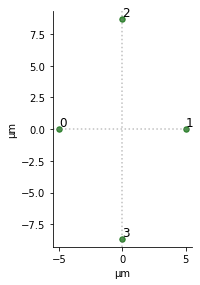

In [22]:
# H2 Molecule : 4 qubits in Jordan-Wigner mapping of the Hamiltonian
a = 10
reg = Register.from_coordinates([[0, 0], [a, 0], [0.5*a, a*np.sqrt(3)/2], [0.5*a, -a*np.sqrt(3)/2]])
reg.draw()

Let us keep the exact ground-state energy of the molecule for future reference, by diagonalizing it exactly - this is possible for such a small system, however, this quickly becomes an intractable problem for large molecules.

In [23]:
def cost_hamiltonian_JW():
    H = - coeff_fact[0] * paulis[0] \
        + coeff_fact[1] * paulis[1] \
        - coeff_fact[2] * paulis[2] \
        + coeff_fact[3] * paulis[3] \
        + coeff_fact[4] * paulis[4] \
        + coeff_fact[5] * paulis[5] \
        + coeff_fact[6] * paulis[6] \
        - coeff_fact[7] * paulis[7] \
        + coeff_fact[7] * paulis[8]
    return H

global H
H = cost_hamiltonian_JW()
exact_energy, ground_state = cost_hamiltonian_JW().groundstate()
print(exact_energy)

-1.8510459284448646


### Quantum Loop (VQS)

Much like in the *Using QAOA to solve a MIS problem* notebook, we will use a mixed classical-quantum approach for minimizing the energy. The quantum part will do the exploration in Hilbert space, according to a certain set of parameters $\theta_i, \tau_j$, and the classical part will find the optimal parameters given the value of the energy after each loop. For now, we will ignore sampling problems and simply compute the exact expectation value of $H_{JW}$. See [this article by Xiao Yuan et al.](https://arxiv.org/abs/1812.08767) for details about VQS algorithms.

Two mixing Hamiltonians are used for the exploration of the solution space :
$H_1 = \hbar / 2 \sum_i \sigma_i^x + \sum_{j<i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} \hat n_i \hat n_j$ and $H_2 = H_1 + \hbar / 2 \sum_i \sigma_i^z$.
We apply them repeatedly one after the other in $p$ layers. In total, $2p$ unitaries $U(\theta_i, H_1) = \exp(-i \theta_i H_1)$ and $U(\tau_i, H_2) = \exp(-i \tau_i H_2)$ act on the initial state to produce state $|\Psi(\theta, \tau)\rangle$ and measure $H_{JW}$.

In [24]:
def quantum_loop(param, in_state, r=reg):
    """
    Args:
        param (np.array): time parameters for each mixing Hamiltonian. There are 2p time parameters in param.
        in_state (qubit.Qobj): initial state.
    """
    seq = Sequence(r, Chadoq2)
    seq.declare_channel('ch0','rydberg_global')
    middle = len(param)//2
    
    for tau, t in zip(param[middle:], param[:middle]):
        pulse_1 = Pulse.ConstantPulse(tau, 1., 0, 0) 
        pulse_2 = Pulse.ConstantPulse(t, 1., 1., 0) 
        seq.add(pulse_1, 'ch0')
        seq.add(pulse_2, 'ch0')
    
    seq.measure('ground-rydberg')
    simul = Simulation(seq, sampling_rate=.01)
    simul.initial_state = in_state
    results = simul.run()
    return results.expect([H])[-1][-1]

def loop_JW(param, in_state):
    res = minimize(quantum_loop, param, method='Nelder-Mead', args=in_state,
                   options={'return_all':True, 'maxiter':200, 'adaptive':True})
    return(res)

We choose to act on the quantum states with $5$ layers of noncommuting mixing Hamiltonians, and an initial set of parameters such that pulses with Hamiltonian $H_1$ last $2\mu s$, and those with $H_2$ last $4\mu s$.

In [25]:
# Setup for VQS
layers = 5
param = [2000]*layers + [4000]*layers

We now obtain the ground-state energy :

In [26]:
loop_ising_results = loop_JW(param, gggg)
print(loop_ising_results.fun, exact_energy)

-1.8179212931056672 -1.8510459284448646


As we can see, it's not so far off, since we're about $2$% off from the exact value. Adding more layers, tweaking the mixing Hamiltonians or the initial parameters can help with the accuracy. 

Let's see how well the optimizer did after each loop.

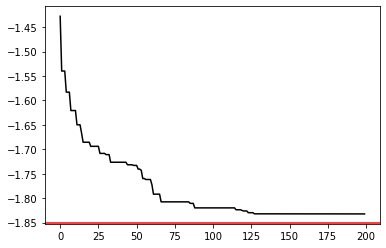

In [13]:
plt.plot([quantum_loop(pars, gggg) for pars in loop_ising_results.allvecs], 'k')
plt.axhline(exact_energy, color='red')

Seems like we can cut on calculation time by only allowing $100$ iterations, since we don't get much more accurate afterwards.

## Estimating Jordan-Wigner $H_2$ Hamiltonian with classical shadows

### Randomized measurements

We now consider the real-life problem where we don't have access to the exact value $\bra{\Psi(\theta_i, \tau_j)} H_{JW} \ket{\Psi(\theta_i, \tau_j)}$. It can be estimated with calssical shadows.
We modify the quantum loop to add classical shadow estimation of the several Pauli strings making up the $H_{JW}$ Hamiltonian : this is the perfect setting to do so, because we have multiple Pauli strings and most of them have low weight.

In [27]:
def exp_value_JW(exp_values):
    return (- coeff_fact[0] * exp_values[0] \
            + coeff_fact[1] * exp_values[1] \
            - coeff_fact[2] * exp_values[2] \
            + coeff_fact[3] * exp_values[3] \
            + coeff_fact[4] * exp_values[4] \
            + coeff_fact[5] * exp_values[5] \
            + coeff_fact[6] * exp_values[6] \
            - coeff_fact[7] * exp_values[7] \
            + coeff_fact[7] * exp_values[8])

In [33]:
def quantum_loop_shadows(param, in_state, shadow_size=20, r=reg):
    """
    Args:
        param (np.array): time parameters for each mixing Hamiltonian. There are 2p time parameters in param.
        in_state (qubit.Qobj): initial state.
    """
    seq = Sequence(r, Chadoq2)
    seq.declare_channel('ch0','rydberg_global')
    middle = len(param)//2
    
    for tau, t in zip(param[middle:], param[:middle]):
        pulse_1 = Pulse.ConstantPulse(tau, 1., 0, 0) 
        pulse_2 = Pulse.ConstantPulse(t, 1., 1., 0)
        seq.add(pulse_1, 'ch0')
        seq.add(pulse_2, 'ch0')
    
    seq.measure('ground-rydberg')
    simul = Simulation(seq, sampling_rate=.01)
    simul.initial_state = in_state
    
    # Classical shadow estimation
    #shadow_size, K = compute_shadow_size(0.1, 0.5, paulis)
    K = 4
    rho = simul.run().get_final_state().proj()
    outcomes, unitary_ids = calculate_classical_shadow(rho, shadow_size)
    snapshots = [snapshot_state(outcomes[ns], unitary_ids[ns]) for ns in range(shadow_size)]
    meds = [_median_of_means(obs, snapshots, K) for obs in paulis]
    return exp_value_JW(meds)

def loop_JW_shadows(param, in_state, shadow_size=20):
    res = minimize(quantum_loop_shadows, param, method='Nelder-Mead', args=(in_state, shadow_size),
                   options={'return_all':True, 'maxiter':100, 'adaptive':True})
    return(res)

In [34]:
%%time
loop_results_shadows = loop_JW_shadows(param, gggg, 20)
print(loop_results_shadows.fun, exact_energy)

-2.252696399999998 -1.8510459284448646
CPU times: user 18.3 s, sys: 57.3 ms, total: 18.3 s
Wall time: 18.3 s


In [39]:
shadow_sizes = [10,20,40,60,80,100]
energies = []
for shadow_size in shadow_sizes:
    energies.append(abs(loop_JW_shadows(param, gggg, shadow_size=shadow_size).fun - exact_energy))

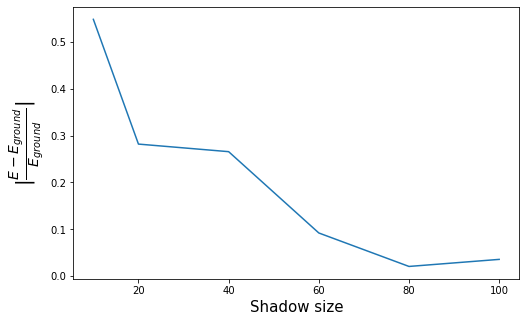

In [57]:
plt.figure(figsize=(8,5))
plt.xlabel("Shadow size", fontsize=15)
plt.ylabel(r"$|\frac{E - E_{ground}}{E_{ground}}|$", fontsize=20)
plt.plot(shadow_sizes, [-e/exact_energy for e in energies])

As could be expected, the estimation can be worse than what we got before : we added both randomness and sampling issues to the problem. However, raising shadow size will allow more and more precise results. However, it can also be closer to the exact value for the same reasons.

### Derandomized measurements

Finally, we try out the derandomized measurements method. To implement this one, we need to decompose the Hamiltonian into individual Pauli strings, rather than group them when they share the same leading coefficient as we did before, as it reduced the number of estimations.

In [59]:
coeff_non_fact = [-0.81261,
                  0.171201,
                  0.171201,
                  -0.2227965,
                  -0.2227965,
                  0.16862325,
                  0.174349,
                  0.12054625,
                  0.12054625,
                  0.165868,
                  0.165868,
                  -0.04532175,
                  -0.04532175,
                  0.04532175,
                  0.04532175]

paulis_str = ["1111", "Z111", "1Z11", "11Z1", "111Z", "ZZ11", "11ZZ", "Z1Z1", "1Z1Z", "1ZZ1",
              "Z11Z", "YYXX", "XXYY", "XYYX", "YXXY"]

In [60]:
def exp_value_JW_non_fact(outcomes):
    return sum([c*exp_value(sigma, outcomes) for c, sigma in zip(coeff_non_fact, paulis_str)])

Then, we ask the derandomization algorithm to return $60$ suitable Pauli measurements regarding our input Pauli observables. $60$ is arbitrary, but is small enough that the algorithm runs quickly and large enough that it gives good results.

In [68]:
measurements = derandomization(60, paulis_str)
print(measurements)

def quantum_loop_derand(param, in_state, r=reg):
    """
    Args:
        param (np.array): time parameters for each mixing Hamiltonian. There are 2p time parameters in param.
        in_state (qubit.Qobj): initial state.
    """
    seq = Sequence(r, Chadoq2)
    seq.declare_channel('ch0','rydberg_global')
    middle = len(param)//2
    
    for tau, t in zip(param[middle:], param[:middle]):
        pulse_1 = Pulse.ConstantPulse(tau, 1., 0, 0) 
        pulse_2 = Pulse.ConstantPulse(t, 1., 1., 0)
        seq.add(pulse_1, 'ch0')
        seq.add(pulse_2, 'ch0')
    
    seq.measure('ground-rydberg')
    simul = Simulation(seq, sampling_rate=.01)
    simul.initial_state = in_state
    
    # Classical shadow estimation
    rho = simul.run().get_final_state().proj()
    outcomes = classical_shadow_derand(rho, measurements)
    return exp_value_JW_non_fact(outcomes)

def loop_JW_derand(param, in_state):
    res = minimize(quantum_loop_derand, param, method='Nelder-Mead', args=in_state,
                   options={'return_all':True, 'maxiter':150, 'adaptive':True})
    return(res)

['ZZZZ', 'ZZZZ', 'ZZZZ', 'ZZZZ', 'ZZZZ', 'ZZZZ', 'ZZZZ', 'ZZZZ', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'ZZZZ', 'XXYY', 'YYXX', 'XYYX', 'YXXY', 'ZZZZ', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'ZZZZ', 'XXYY', 'YYXX', 'XYYX', 'YXXY', 'ZZZZ', 'XXYY', 'YXXY', 'YYXX', 'XYYX', 'ZZZZ', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'ZZZZ', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'ZZZZ', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'ZZZZ', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'ZZZZ', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'ZZZZ', 'XXYY', 'YXXY']


In [71]:
print(measurements.count('ZZZZ'), measurements.count('XXYY'), measurements.count('YXXY'), measurements.count('XYYX'))

18 11 11 10


As we can see, since all Pauli observables appearing in the Jordan-Wigner Hamiltonian involving the $Z$-basis never involve another basis, we find that it is always worth it to measure Pauli string $ZZZZ$ rather than $ZZZX$, or $ZYZZ$, etc. This is a sign that our cost function is doing its job !

In [723]:
%%time
loop_results_shadows = loop_JW_derand(param, gggg)
print(loop_results_shadows.fun, exact_energy)

-1.8649451570707067 -1.8510459284448646
CPU times: user 24.8 s, sys: 132 ms, total: 25 s
Wall time: 25 s


In [65]:
measurement_sizes = [20,30,40,60,80,100]
energies_derand = []
for meas_size in measurement_sizes:
    measurements=derandomization(meas_size, paulis_str)
    energies_derand.append(abs(loop_JW_derand(param, gggg).fun - exact_energy) / abs(exact_energy))

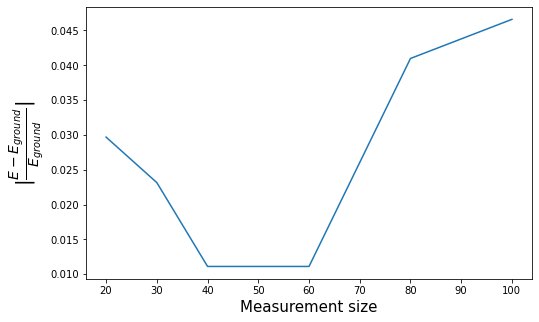

In [66]:
plt.figure(figsize=(8,5))
plt.xlabel("Measurement size", fontsize=15)
plt.ylabel(r"$|\frac{E - E_{ground}}{E_{ground}}|$", fontsize=20)
plt.plot(measurement_sizes, energies_derand)

We consistently obtain accurate results using this derandomized technique, and we obtain them far quicker than when dealing with randomized classical shadows. For roughly the same number of samples ($\sim 60$ for each method, be it for shadow size or number of measurements), we experience much less computing time using the derandomized method. This was to be expected : by restricting the observables to Pauli strings, we allow for efficient estimation that can be easily computed in $O(M\times n)$, as well as remove randomness problematic with higher-weight observables (such as $YYXX$ or $YXXY$).